In [21]:
import numpy as np
import glob
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from scipy.stats import wilcoxon
import ast

In [22]:
fileNames2D = np.sort(glob.glob("./data/zheng/processed_interactions_p4/*"))
#fileNames2D = np.sort(glob.glob("./data/zheng/processed_interactions_p3/*"))

In [23]:
fileNames2D

array(['./data/zheng/processed_interactions_p4/pro13_ace_p4_logs.csv',
       './data/zheng/processed_interactions_p4/pro15_ade_p4_logs.csv',
       './data/zheng/processed_interactions_p4/pro17_ace_p4_logs.csv',
       './data/zheng/processed_interactions_p4/pro18_adf_p4_logs.csv',
       './data/zheng/processed_interactions_p4/pro20_ade_p4_logs.csv',
       './data/zheng/processed_interactions_p4/pro21_ade_p4_logs.csv',
       './data/zheng/processed_interactions_p4/pro22_ade_p4_logs.csv',
       './data/zheng/processed_interactions_p4/pro23_acf_p4_logs.csv',
       './data/zheng/processed_interactions_p4/pro24_adf_p4_logs.csv',
       './data/zheng/processed_interactions_p4/pro25_acf_p4_logs.csv',
       './data/zheng/processed_interactions_p4/pro29_ace_p4_logs.csv',
       './data/zheng/processed_interactions_p4/pro31_adf_p4_logs.csv',
       './data/zheng/processed_interactions_p4/pro3_ace_p4_logs.csv',
       './data/zheng/processed_interactions_p4/pro5_adf_p4_logs.csv',
       '

In [24]:
def get_probabilities_action(dataframe, current_phase):
    actions = ['same', 'modify-1', 'modify-2', 'modify-3']

    # Initialize a dictionary with small default probabilities to avoid division by zero
    probabilities = dict.fromkeys(actions, 0.0000000000000000001)

    # Count occurrences of each action
    action_counts = dataframe['Action'].value_counts()

    # Update probabilities based on counts
    for action in actions:
        if action in action_counts:
            probabilities[action] = action_counts[action] / len(dataframe)

    return probabilities[current_phase]

In [25]:
import ast

def get_probabilities(dataframe, current_phase):
    map = ['Title', 'US_Gross', 'Worldwide_Gross', 'US_DVD_Sales', 'Production_Budget', 'Release_Date',
           'MPAA_Rating', 'Running_Time_min', 'Distributor', 'Source', 'Major_Genre', 'Creative_Type',
           'Director', 'Rotten_Tomatoes_Rating', 'IMDB_Rating', 'IMDB_Votes', 'None']

    # Initialize dictionary to store counts
    dict_map = dict.fromkeys(map, 0)

    # Count occurrences of each field
    total_count = 0
    for index, row in dataframe.iterrows():
        for field in ast.literal_eval(row['Attribute']):
            dict_map[field] += 1
            total_count += 1

    # # Calculate probabilities
    # probabilities = {}
    # for field, count in dict_map.items():
    #     probabilities[field] = count / total_count

    return dict_map[current_phase]

# Example usage:
# Assuming 'dataframe' is your DataFrame and 'current_phase' is the phase you want to get the probability for
# probability = get_probabilities(dataframe, current_phase)


In [26]:
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
        self.trend= None

    def Wilcoxon_Test(self,series_X, series_Y):

        return wilcoxon(series_X, series_Y)


In [27]:
import pandas as pd
import numpy as np
import warnings

def split_dataframe(df, splits=4):
    # Sort the DataFrame by the "Time" column
    df = df.sort_values(by="Time")

    # Get the minimum and maximum UNIX timestamps
    min_time = df['Time'].min()
    max_time = df['Time'].max()

    # Calculate the time interval size
    interval_size = (max_time - min_time) / splits

    slices = []
    start_time = min_time
    for i in range(splits):
        # Determine the end time of the current interval
        end_time = start_time + interval_size

        # Filter the DataFrame based on the time range
        slice_df = df[(df['Time'] >= start_time) & (df['Time'] < end_time)].reset_index(drop=True)

        slices.append(slice_df)

        # Update the start time for the next interval
        start_time = end_time

    return slices
# Initialize an empty list to store print information
print_info = []

# Suppress FutureWarning related to DataFrame concatenation
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    all_pvalue = []
    # for state in ['Title', 'US_Gross', 'Worldwide_Gross', 'US_DVD_Sales', 'Production_Budget', 'Release_Date',
    #               'MPAA_Rating', 'Running_Time_min', 'Distributor', 'Source', 'Major_Genre', 'Creative_Type',
    #               'Director', 'Rotten_Tomatoes_Rating', 'IMDB_Rating', 'IMDB_Votes', 'None']:
    for state in ['same', 'modify-1', 'modify-2', 'modify-3']:
        print(f"\nProcessing test for action: {state}")
        test_dfs = pd.DataFrame(columns=['User', 'First_Half', 'Second_Half'])
        for i, u in enumerate(fileNames2D):
            df = pd.read_csv(u)
            # mid = round(len(df) / 2)
            # slice1 = df[:mid].reset_index(drop=True)
            # slice2 = df[mid:].reset_index(drop=True)
            slices = split_dataframe(df, splits=2)
            probab_1 = get_probabilities_action(slices[0], state)
            probab_2 = get_probabilities_action(slices[1], state)
            user_df = pd.DataFrame({'User': [u], 'First_Half': [probab_1], 'Second_Half': [probab_2]})
            test_dfs = pd.concat([test_dfs, user_df], ignore_index=True)

        stats_test = StationarityTests()
        result = stats_test.Wilcoxon_Test(test_dfs['First_Half'], test_dfs['Second_Half'])
        all_pvalue.append(result.pvalue)

        # Append the print information to the list
        print_info.append((state, np.mean(test_dfs['First_Half']), np.mean(test_dfs['Second_Half']), result.pvalue))

# Create a DataFrame from the list of print information
df_print_info = pd.DataFrame(print_info, columns=['Action', 'Mean_First_Half', 'Mean_Second_Half', 'P-Value'])



Processing test for action: same

Processing test for action: modify-1

Processing test for action: modify-2

Processing test for action: modify-3


In [28]:
df_print_info

,Action,Mean_First_Half,Mean_Second_Half,P-Value
0,same,0.592688,0.593623,0.498910
1,modify-1,0.212741,0.183990,0.156816
2,modify-2,0.129994,0.155854,0.818630
3,modify-3,0.064576,0.066533,0.724285


In [20]:
stats_test = StationarityTests()
result = stats_test.Wilcoxon_Test(df_print_info['Mean_First_Half'], df_print_info['Mean_Second_Half'])
result

WilcoxonResult(statistic=4.0, pvalue=0.875)

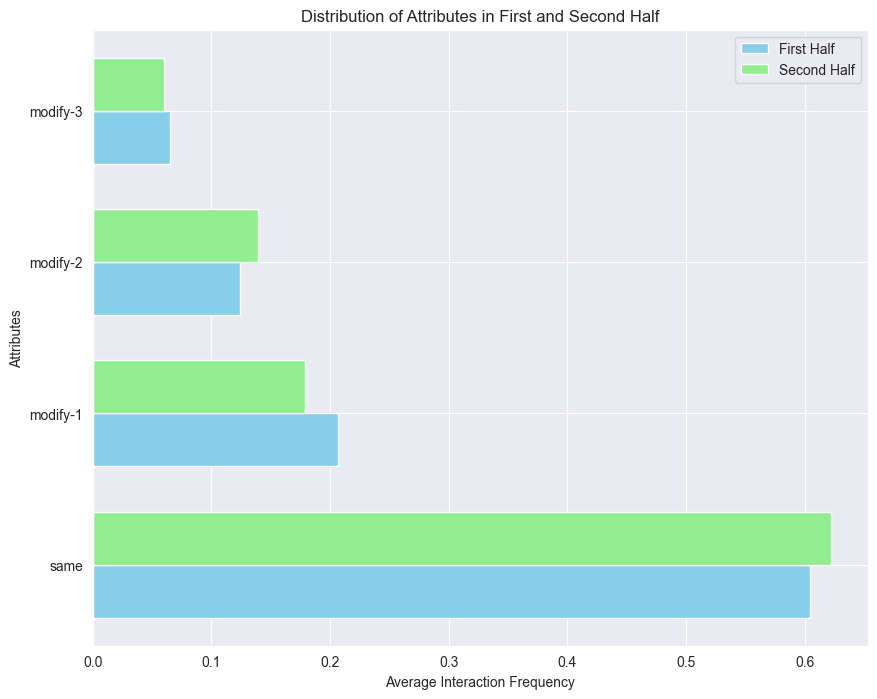

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Exclude 'None' action from the DataFrame
df_print_info_filtered = df_print_info[df_print_info['Action'] != 'None']

# Sort DataFrame by mean probabilities in the first half
df_sorted_first_half = df_print_info_filtered.sort_values(by='Mean_First_Half', ascending=False)

# Sort DataFrame by mean probabilities in the second half
df_sorted_second_half = df_print_info_filtered.sort_values(by='Mean_Second_Half', ascending=False)

# Create an array for the y-axis positions
y_positions = np.arange(len(df_sorted_first_half))

# Set the height of the bars
bar_height = 0.35

# Plot grouped horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 8))
bar1 = ax.barh(y_positions - bar_height/2, df_sorted_first_half['Mean_First_Half'], bar_height, label='First Half', color='skyblue')
bar2 = ax.barh(y_positions + bar_height/2, df_sorted_second_half['Mean_Second_Half'], bar_height, label='Second Half', color='lightgreen')

ax.set_ylabel('Attributes')
ax.set_xlabel('Average Interaction Frequency')
ax.set_title('Distribution of Attributes in First and Second Half')
ax.set_yticks(y_positions)
ax.set_yticklabels(df_sorted_first_half['Action'])
ax.legend()

# Display the value next to the bars
def autolabel(bars, ranks_changed):
    for bar, rank_changed in zip(bars, ranks_changed):
        width = bar.get_width()
        # ax.annotate(f'{width:.3f}', xy=(width, bar.get_y() + bar.get_height() / 2),
        #             xytext=(3, 0), textcoords='offset points', ha='left', va='center')
        if rank_changed:
            ax.annotate('Rank Changed', xy=(width, bar.get_y() + bar.get_height() / 2),
                        xytext=(3, 0), textcoords='offset points', ha='left', va='center', color='red')

# Determine if the rank has changed
ranks_changed = df_sorted_first_half.index != df_sorted_second_half.index

autolabel(bar1, ranks_changed)
autolabel(bar2, [])

plt.show()


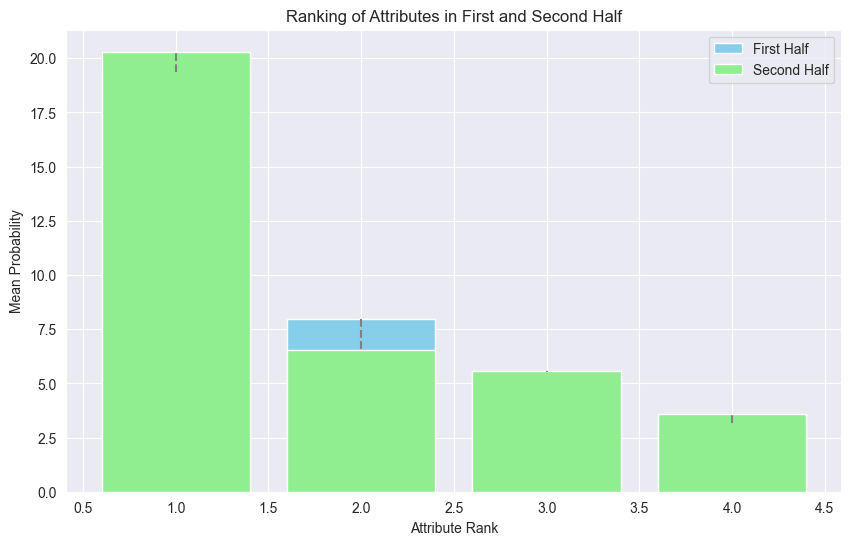

In [22]:
import matplotlib.pyplot as plt

# Exclude 'None' action from the DataFrame
df_print_info_filtered = df_print_info[df_print_info['Action'] != 'None']

# Sort DataFrame by mean probabilities in the first half
df_sorted_first_half = df_print_info_filtered.sort_values(by='Mean_First_Half', ascending=False)

# Sort DataFrame by mean probabilities in the second half
df_sorted_second_half = df_print_info_filtered.sort_values(by='Mean_Second_Half', ascending=False)

# Create an array for the x-axis positions
x_positions_first_half = range(1, len(df_sorted_first_half) + 1)
x_positions_second_half = range(1, len(df_sorted_second_half) + 1)

# Plot bar chart for the first half
plt.figure(figsize=(10, 6))
plt.bar(x_positions_first_half, df_sorted_first_half['Mean_First_Half'], label='First Half', color='skyblue')

# Plot bar chart for the second half
plt.bar(x_positions_second_half, df_sorted_second_half['Mean_Second_Half'], label='Second Half', color='lightgreen')

# Connect the corresponding ranks with lines
for x1, x2, y1, y2 in zip(x_positions_first_half, x_positions_second_half, df_sorted_first_half['Mean_First_Half'], df_sorted_second_half['Mean_Second_Half']):
    plt.plot([x1, x2], [y1, y2], color='gray', linestyle='dashed')

plt.xlabel('Attribute Rank')
plt.ylabel('Mean Probability')
plt.title('Ranking of Attributes in First and Second Half')
plt.legend()
plt.show()


In [23]:
from scipy import stats
stats.false_discovery_control(all_pvalue,method='bh')

array([0.37480936, 0.37480936, 0.9250833 , 0.37480936])

In [24]:
from statsmodels.stats.multitest import multipletests
multipletests(all_pvalue,alpha=0.05,method='bonferroni')

(array([False, False, False, False]),
 array([1.        , 0.61659039, 1.        , 1.        ]),
 0.012741455098566168,
 0.0125)

In [25]:
test_dfs

,User,First_Half,Second_Half
0,./data/zheng/processed_interactions_p4/pro13_a...,4.545455e-02,4.545455e-02
1,./data/zheng/processed_interactions_p4/pro15_a...,1.000000e-19,1.000000e-19
2,./data/zheng/processed_interactions_p4/pro17_a...,1.029412e-01,1.194030e-01
3,./data/zheng/processed_interactions_p4/pro18_a...,1.000000e-19,1.000000e-19
4,./data/zheng/processed_interactions_p4/pro20_a...,1.000000e-19,5.769231e-02
5,./data/zheng/processed_interactions_p4/pro21_a...,1.000000e-01,1.147541e-01
6,./data/zheng/processed_interactions_p4/pro22_a...,2.500000e-02,7.500000e-02
7,./data/zheng/processed_interactions_p4/pro23_a...,1.666667e-01,1.200000e-01
8,./data/zheng/processed_interactions_p4/pro24_a...,1.428571e-01,1.379310e-01
9,./data/zheng/processed_interactions_p4/pro25_a...,6.250000e-02,6.451613e-02


In [145]:
import pandas as pd

# Data for Task 1
data_task1 = {
    'State': ['same', 'modify-1', 'modify-2', 'modify-3'],
    'Probabilities': [
        (0.8876093163191814, 0.9036706608001557),
        (0.05956601207253228, 0.04030519668487754),
        (0.03314789227099658, 0.033902971550730215),
        (0.01967677933728982, 0.022121170964236613)
    ],
    'Users are Non-stationary': [False, True, False, False],
    'p-value': [0.2591549908058598, 0.04757850903792886, 0.7681320131051164, 0.3818598292804778]
}

# Create DataFrame for Task 1
df_task1 = pd.DataFrame(data_task1)

# Add 'Task' column and fill it with values 1
df_task1['Task'] = 1

# Split 'Probabilities' into two columns
df_task1[['First Probability', 'Second Probability']] = pd.DataFrame(df_task1['Probabilities'].tolist(), index=df_task1.index)

# Drop the original 'Probabilities' column
df_task1 = df_task1.drop('Probabilities', axis=1)

# Display the DataFrame for Task 1
print("DataFrame for Task 1:")
print(df_task1)
print("\n")

# Data for Task 2
data_task2 = {
    'State': ['same', 'modify-1', 'modify-2', 'modify-3'],
    'Probabilities': [
        (0.9125182383830589, 0.9027729097344456),
        (0.031555230753115115, 0.03193133006235149),
        (0.02318395800221173, 0.027343146760141088),
        (0.03274257286161427, 0.037952613443061785)
    ],
    'Users are Non-stationary': [False, False, False, False],
    'p-value': [0.5857675045372053, 0.8853820274047068, 0.24937965121897676, 0.9753871641763363]
}

# Create DataFrame for Task 2
df_task2 = pd.DataFrame(data_task2)

# Add 'Task' column and fill it with values 2
df_task2['Task'] = 2

# Split 'Probabilities' into two columns
df_task2[['First Probability', 'Second Probability']] = pd.DataFrame(df_task2['Probabilities'].tolist(), index=df_task2.index)

# Drop the original 'Probabilities' column
df_task2 = df_task2.drop('Probabilities', axis=1)

# Display the DataFrame for Task 2
print("DataFrame for Task 2:")
print(df_task2)
print("\n")

# Data for Task 3
data_task3 = {
    'State': ['same', 'modify-1', 'modify-2', 'modify-3'],
    'Probabilities': [
        (0.9084316525880721, 0.917136389331875),
        (0.04584876310294898, 0.03622554581019788),
        (0.03135581352845592, 0.030568388206083597),
        (0.01436377078052304, 0.016069676651843376)
    ],
    'Users are Non-stationary': [False, False, False, False],
    'p-value': [0.6807392418850213, 0.3255830180830511, 0.9522839464653821, 0.6486563230628954]
}

# Create DataFrame for Task 3
df_task3 = pd.DataFrame(data_task3)

# Add 'Task' column and fill it with values 3
df_task3['Task'] = 3

# Split 'Probabilities' into two columns
df_task3[['First Probability', 'Second Probability']] = pd.DataFrame(df_task3['Probabilities'].tolist(), index=df_task3.index)

# Drop the original 'Probabilities' column
df_task3 = df_task3.drop('Probabilities', axis=1)

# Display the DataFrame for Task 3
print("DataFrame for Task 3:")
print(df_task3)
print("\n")

# Data for Task 4
data_task4 = {
    'State': ['same', 'modify-1', 'modify-2', 'modify-3'],
    'Probabilities': [
        (0.9224248552654282, 0.9276382446493182),
        (0.03914483562120856, 0.03410255205968483),
        (0.02589302661197498, 0.024497613235258786),
        (0.012537282501388271, 0.013761590055738116)
    ],
    'Users are Non-stationary': [False, False, False, False],
    'p-value': [0.31723979237390443, 0.0690511620712648, 0.4886806017769275, 0.537722120370485]
}

# Create DataFrame for Task 4
df_task4 = pd.DataFrame(data_task4)

# Add 'Task' column and fill it with values 4
df_task4['Task'] = 4

# Split 'Probabilities' into two columns
df_task4[['First Probability', 'Second Probability']] = pd.DataFrame(df_task4['Probabilities'].tolist(), index=df_task4.index)

# Drop the original 'Probabilities' column
df_task4 = df_task4.drop('Probabilities', axis=1)

# Display the DataFrame for Task 4
print("DataFrame for Task 4:")
print(df_task4)
print("\n")

# Combine all DataFrames into a single DataFrame
df_combined = pd.concat([df_task1, df_task2, df_task3, df_task4], ignore_index=True)

# Display the combined DataFrame
print("Combined DataFrame:")
print(df_combined)


DataFrame for Task 1:
      State  Users are Non-stationary   p-value  Task  First Probability  \
0      same                     False  0.259155     1           0.887609   
1  modify-1                      True  0.047579     1           0.059566   
2  modify-2                     False  0.768132     1           0.033148   
3  modify-3                     False  0.381860     1           0.019677   

   Second Probability  
0            0.903671  
1            0.040305  
2            0.033903  
3            0.022121  


DataFrame for Task 2:
      State  Users are Non-stationary   p-value  Task  First Probability  \
0      same                     False  0.585768     2           0.912518   
1  modify-1                     False  0.885382     2           0.031555   
2  modify-2                     False  0.249380     2           0.023184   
3  modify-3                     False  0.975387     2           0.032743   

   Second Probability  
0            0.902773  
1            0.031931  


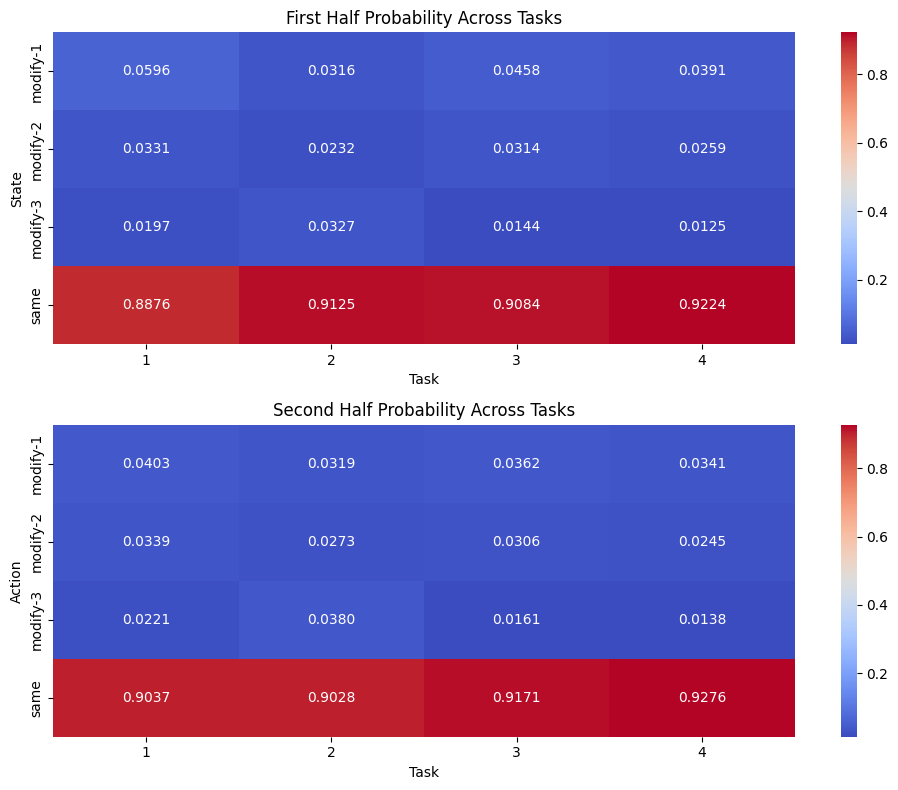

In [240]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Combine all DataFrames into a single DataFrame
df_combined = pd.concat([df_task1, df_task2, df_task3, df_task4], ignore_index=True)

# Create a pivot table for better visualization
pivot_df = df_combined.pivot_table(index='State', columns=['Task'], values=['First Probability', 'Second Probability'])

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=2, figsize=(10, 8))

# Create heatmaps for the first and second probabilities
sns.heatmap(pivot_df['First Probability'], annot=True, cmap='coolwarm', fmt='.4f', ax=axes[0])
sns.heatmap(pivot_df['Second Probability'], annot=True, cmap='coolwarm', fmt='.4f', ax=axes[1])

# Set plot titles and labels
axes[0].set_title('First Half Probability Across Tasks')
axes[1].set_title('Second Half Probability Across Tasks')
plt.xlabel('Task')
plt.ylabel('Action')
# Show the plot
plt.tight_layout()
plt.show()


In [241]:
df_combined

,State,Users are Non-stationary,p-value,Task,First Probability,Second Probability
0,same,False,0.259155,1,0.887609,0.903671
1,modify-1,True,0.047579,1,0.059566,0.040305
2,modify-2,False,0.768132,1,0.033148,0.033903
3,modify-3,False,0.381860,1,0.019677,0.022121
4,same,False,0.585768,2,0.912518,0.902773
5,modify-1,False,0.885382,2,0.031555,0.031931
6,modify-2,False,0.249380,2,0.023184,0.027343
7,modify-3,False,0.975387,2,0.032743,0.037953
8,same,False,0.680739,3,0.908432,0.917136
9,modify-1,False,0.325583,3,0.045849,0.036226


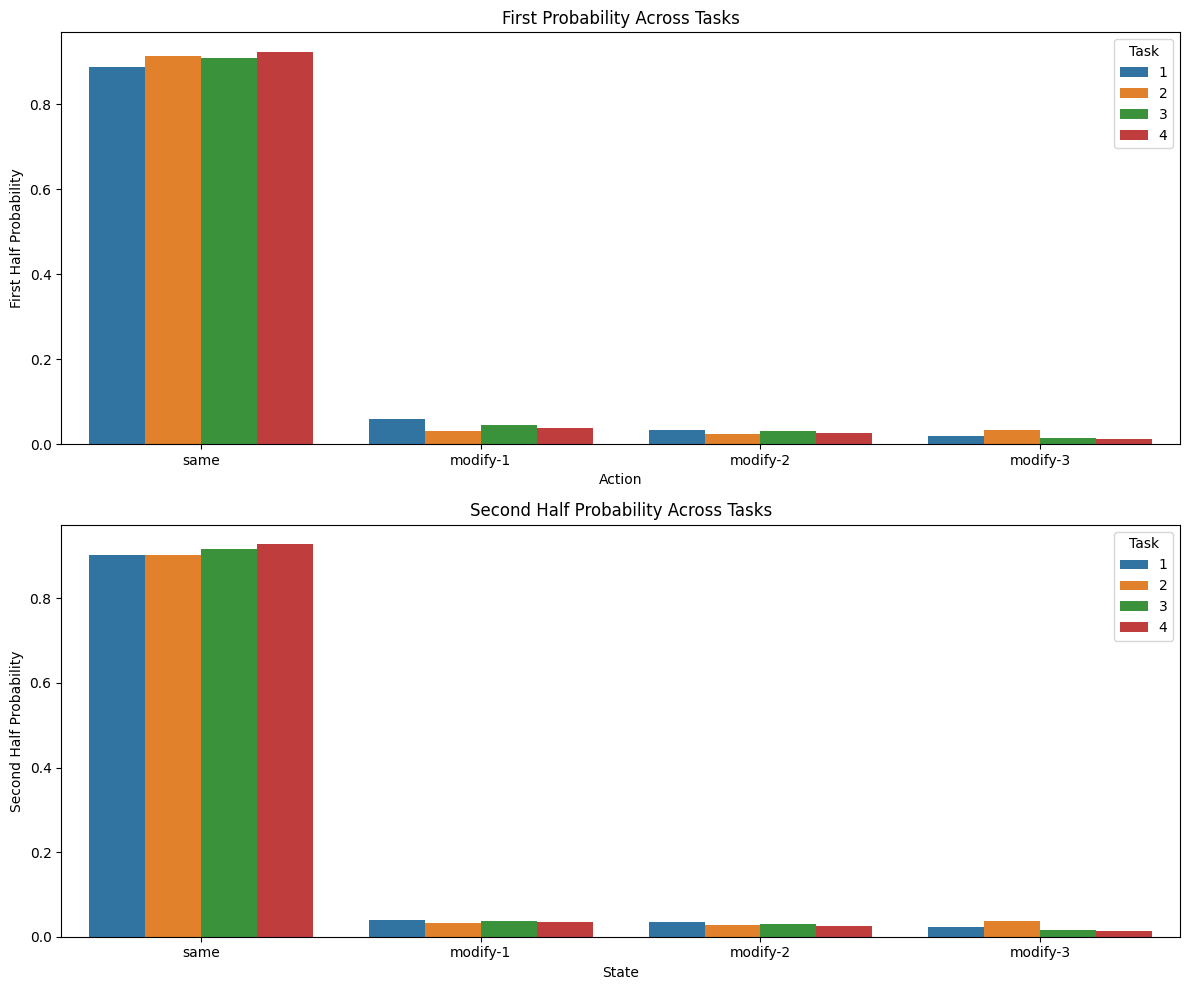

In [246]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Combine all DataFrames into a single DataFrame
df_combined = pd.concat([df_task1, df_task2, df_task3, df_task4], ignore_index=True)

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

# Create a bar plot for both halves with different colors for each task
sns.barplot(x='State', y='First Probability', hue='Task', data=df_combined, ax=axes[0], palette='tab10', errorbar=None)
axes[0].set_title('First Probability Across Tasks')
axes[0].set_ylabel('First Half Probability')
axes[0].set_xlabel('Action')
axes[0].legend(title='Task')

# Create a bar plot for both halves with different colors for each task
sns.barplot(x='State', y='Second Probability', hue='Task', data=df_combined, ax=axes[1], palette='tab10', errorbar=None)
axes[1].set_title('Second Half Probability Across Tasks')
axes[1].set_ylabel('Second Half Probability')
axes[1].legend(title='Task')

# Adjust layout
plt.tight_layout()
plt.show()
